In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
random.seed = 69

In [2]:
def grover_iteration(psi, s, a):
    
    # perform grover iteration on the subarray
    psi[s, a] = -psi[s,a]
    A = np.average(psi[s])
    psi[s] = 2*A - psi[s]
    return psi

def choose_action(psi, Q, s, epsilon):
    '''
    sampling from uniform distribution between 0 and 1. sum the array Q[s] until the index i such that the moving sum is
    more that sampled value. choose that action.
    '''    
    
#     p = np.random.rand()
#     if p < epsilon:
    rand = np.random.rand()
    carrysum = 0
    for i in range(4):
        if psi[s,i] != np.ma.nomask:  # if that index is not masked, sum its value to carrysum
            carrysum = carrysum + psi[s, i]**2
        if carrysum > rand:
            return i
#     else:
#         return np.argmax(Q[s])
    

def learn(Q, s, s_prime, a, envt, lr, gamma):
    '''
    standard RL updation to Q
    '''
    pred = Q[s, a]
    targ = envt[s_prime] - 1 + gamma*np.max(Q[s_prime])
    Q[s, a] = Q[s, a] + lr*(targ - pred)
    return Q

def makeEnvt(M, N):
    envt = np.zeros(N**2)
    holes = random.sample(range(1, N**2-1), M)
    for i in range(N**2):
        if i in holes:
            envt[i] = -100
    envt[N**2 - 1] = 100
    return envt

def play(psi, Q, V, envt, lr, gamma, epsilon, N, k, grover):    
    tot_rew = 0
    steps = 0
#     flag = True
    s = 0
    
    while s != N**2 -1:
        steps = steps + 1
        
        a = choose_action(psi, Q, s, epsilon)
        
        if a == 0:
            s_prime = s - N
        elif a == 1:
            s_prime = s + 1
        elif a == 2:
            s_prime = s + N
        else:
            s_prime = s - 1

#         print("state is", s, "action is", a)
#         print("Q[s]**2 is", np.sum(Q[s]**2))
        reward = envt[s_prime] - 1
        tot_rew = tot_rew + reward
        Q = learn(Q, s, s_prime, a, envt, lr, gamma)
        V[s] = np.sum(psi[s]**2*Q[s])

        L = np.abs(int(k*(reward + V[s_prime])))
        if L>1:
            L = 1

#             if(L > 0):
#                 grover = grover + L
#         print("# of grover iteration:", L)
        for i in range(L):
            psi = grover_iteration(psi, s, a)
        
        s = s_prime
        
        if(steps > 10**4):
            print("help step-brother i'm stuck")
            break

#         if(np.abs(V[s] - V_copy[s]) > epsilon):
#             flag = True
#         print("post grover Q[s]**2 is", np.sum(Q[s]**2), "\n \n")

#         V_copy = V
        # diffs.append(calc_diff(Q_new, Q_old))
    return psi, Q, tot_rew, steps, grover

[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [-100.    0. -100.    0.]
 [-100.    0.    0.  100.]] 



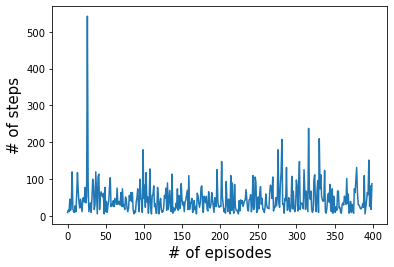

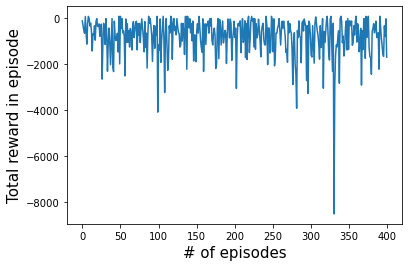

In [4]:
N = 4
M = 3
lr = 0.06
gamma = 0.99
epsilon = 0.10
k = 0.2
rews = []

# envt = makeEnvt(M, N)
np.savetxt('env.csv', envt, delimiter = ',')
print(np.reshape(envt, (N, N)), "\n")
rewards = []
for u in range(1):
    psi = np.ma.ones((N**2, 4))
    Q = np.ma.zeros((N**2, 4))
    for i in range(N**2):
        if i%N == 0:                       # move left
            psi[i,3] = np.ma.masked
            Q[i,3] = np.ma.masked
        if (i+1)%N == 0:                   # move right
            psi[i,1] = np.ma.masked
            Q[i,1] = np.ma.masked
        if i < N:                          # move up
            psi[i,0] = np.ma.masked
            Q[i,0] = np.ma.masked
        if i >= N*(N-1):                   # move down
            psi[i,2] = np.ma.masked  
            Q[i,2] = np.ma.masked
                    
    for i in range(N**2):
        inds = psi[i]!= np.ma.masked 
        normalize = np.sqrt(psi[i,inds].shape)
        psi[i,:] = psi[i,:]/normalize            
            
    rews = []
    steps = []
    grovers = []
    episodes = 400
    V = np.zeros(N**2)
    
    for t in range(episodes):
        psi, Q, rew, step, grover = play(psi, Q, V, envt, lr, gamma, epsilon, N, k, 0)
        steps.append(step)
        grovers.append(grover)
        rews.append(rew)
    rewards.append(rews)

rewards = np.array(rewards)
rewards = np.mean(rewards, 0)
plt.plot(range(episodes), steps)
plt.xlabel('# of episodes', fontsize = 15)
plt.ylabel('# of steps', fontsize = 15)

plt.figure()
plt.plot(rewards)
plt.xlabel('# of episodes', fontsize = 15)
plt.ylabel('Total reward in episode', fontsize = 15)

plt.show()